In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

# 데이터 로드 및 전처리 (이전 코드 그대로 사용)
df = pd.read_csv('ELG_Busan_PoC_per_CA_site_0226_0519.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 1시간 간격으로 데이터 리샘플링
df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'mean'}).reset_index()

# 요일 및 시간 정보 추가
df_hourly['day_of_week'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['hour'] = df_hourly['timestamp'].dt.hour
df_hourly['is_weekend'] = df_hourly['day_of_week'].isin([5, 6])

# 일주일 동안의 시간별 트래픽 패턴 생성
weekly_pattern = df_hourly.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1,2])
weekly_pattern.columns = [f'day{day}_hour{hour}' for day, hour in weekly_pattern.columns]

# k-Shape 클러스터링을 위해 시계열 데이터를 3차원 배열로 변환
time_series_data = to_time_series_dataset(weekly_pattern.fillna(0).values)

# 시계열 데이터를 정규화
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # 평균을 0, 분산을 1로 맞춤
time_series_data_scaled = scaler.fit_transform(time_series_data)

# k-Shape 클러스터링 수행
n_clusters = 5  # 클러스터 수는 필요에 따라 조정 가능
kshape = KShape(n_clusters=n_clusters, random_state=42)
cluster_labels = kshape.fit_predict(time_series_data_scaled)

# 결과를 원본 데이터에 추가
weekly_pattern['cluster'] = cluster_labels

# 클러스터별 RBused의 평균 계산
cluster_means = weekly_pattern.groupby('cluster').mean()

/var/folders/6y/gvfh979s4nb35bcvpht0ntlm0000gn/T/ipykernel_1547/984681688.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'mean'}).reset_index()


Overall Silhouette Score: 0.133


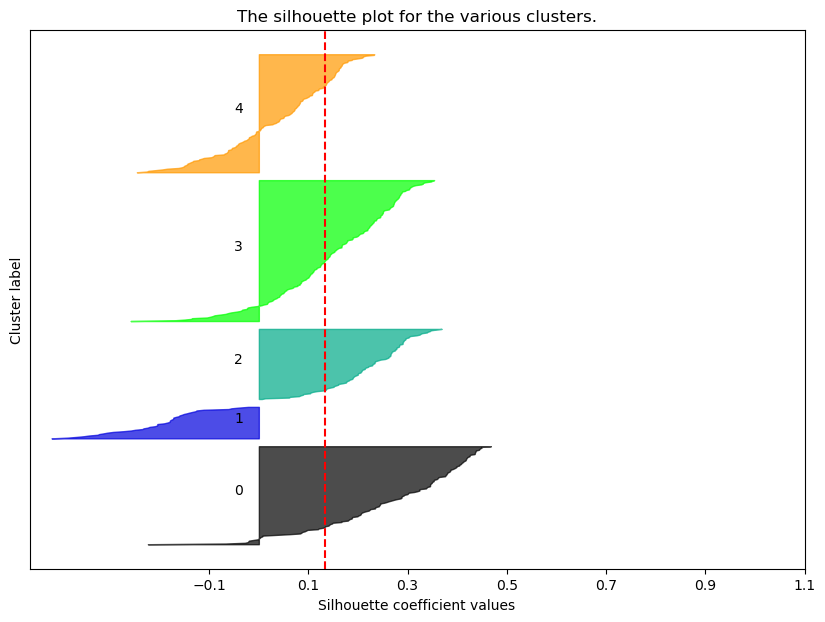

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# 시계열 데이터를 k-Shape 클러스터링에 사용한 후의 레이블을 바탕으로 실루엣 점수 계산
silhouette_avg = silhouette_score(time_series_data_scaled.reshape(time_series_data_scaled.shape[0], -1), cluster_labels)
print(f"Overall Silhouette Score: {silhouette_avg:.3f}")

# 각 데이터 포인트의 실루엣 계수 계산
sample_silhouette_values = silhouette_samples(time_series_data_scaled.reshape(time_series_data_scaled.shape[0], -1), cluster_labels)

# 실루엣 분석 결과 시각화
fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
for i in range(n_clusters):
    # 현재 클러스터의 실루엣 계수 추출 및 정렬
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 다음 클러스터를 위한 y 좌표 조정

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# 실루엣 계수의 평균과 기준선 그리기
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()


Clusters: 2, Davies-Bouldin Index: 1.235
Clusters: 3, Davies-Bouldin Index: 1.809
Clusters: 4, Davies-Bouldin Index: 2.628
Clusters: 5, Davies-Bouldin Index: 2.445
Clusters: 6, Davies-Bouldin Index: 2.814
Clusters: 7, Davies-Bouldin Index: 3.028
Clusters: 8, Davies-Bouldin Index: 2.845
Clusters: 9, Davies-Bouldin Index: 2.669
Clusters: 10, Davies-Bouldin Index: 2.361

Optimal number of clusters based on DB Index: 2


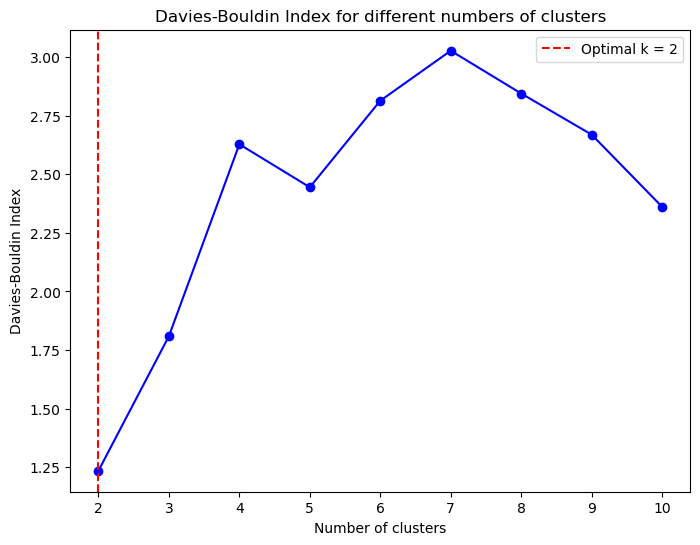

In [13]:
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# K-Shape 클러스터링과 실루엣 점수를 기반으로 최적의 클러스터 수를 찾는 함수
def find_optimal_clusters(time_series_data_scaled, max_clusters=10):
    silhouette_scores = []
    k_values = range(2, max_clusters + 1)

    for k in k_values:
        kshape = KShape(n_clusters=k, random_state=42)
        cluster_labels = kshape.fit_predict(time_series_data_scaled)

        # 시계열 데이터를 2D로 변환하여 실루엣 점수를 계산
        silhouette_avg = silhouette_score(time_series_data_scaled.reshape(time_series_data_scaled.shape[0], -1), cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Clusters: {k}, Silhouette Score: {silhouette_avg:.3f}")
    
    # 최적의 클러스터 수 선택
    optimal_k = k_values[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k} with a Silhouette Score of {max(silhouette_scores):.3f}")

    # 실루엣 점수 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, silhouette_scores, 'bo-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores for different numbers of clusters")
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.legend()
    plt.show()

    return optimal_k

# 함수 호출 및 최적의 클러스터 수 찾기
optimal_clusters = find_optimal_clusters(time_series_data_scaled, max_clusters=10)


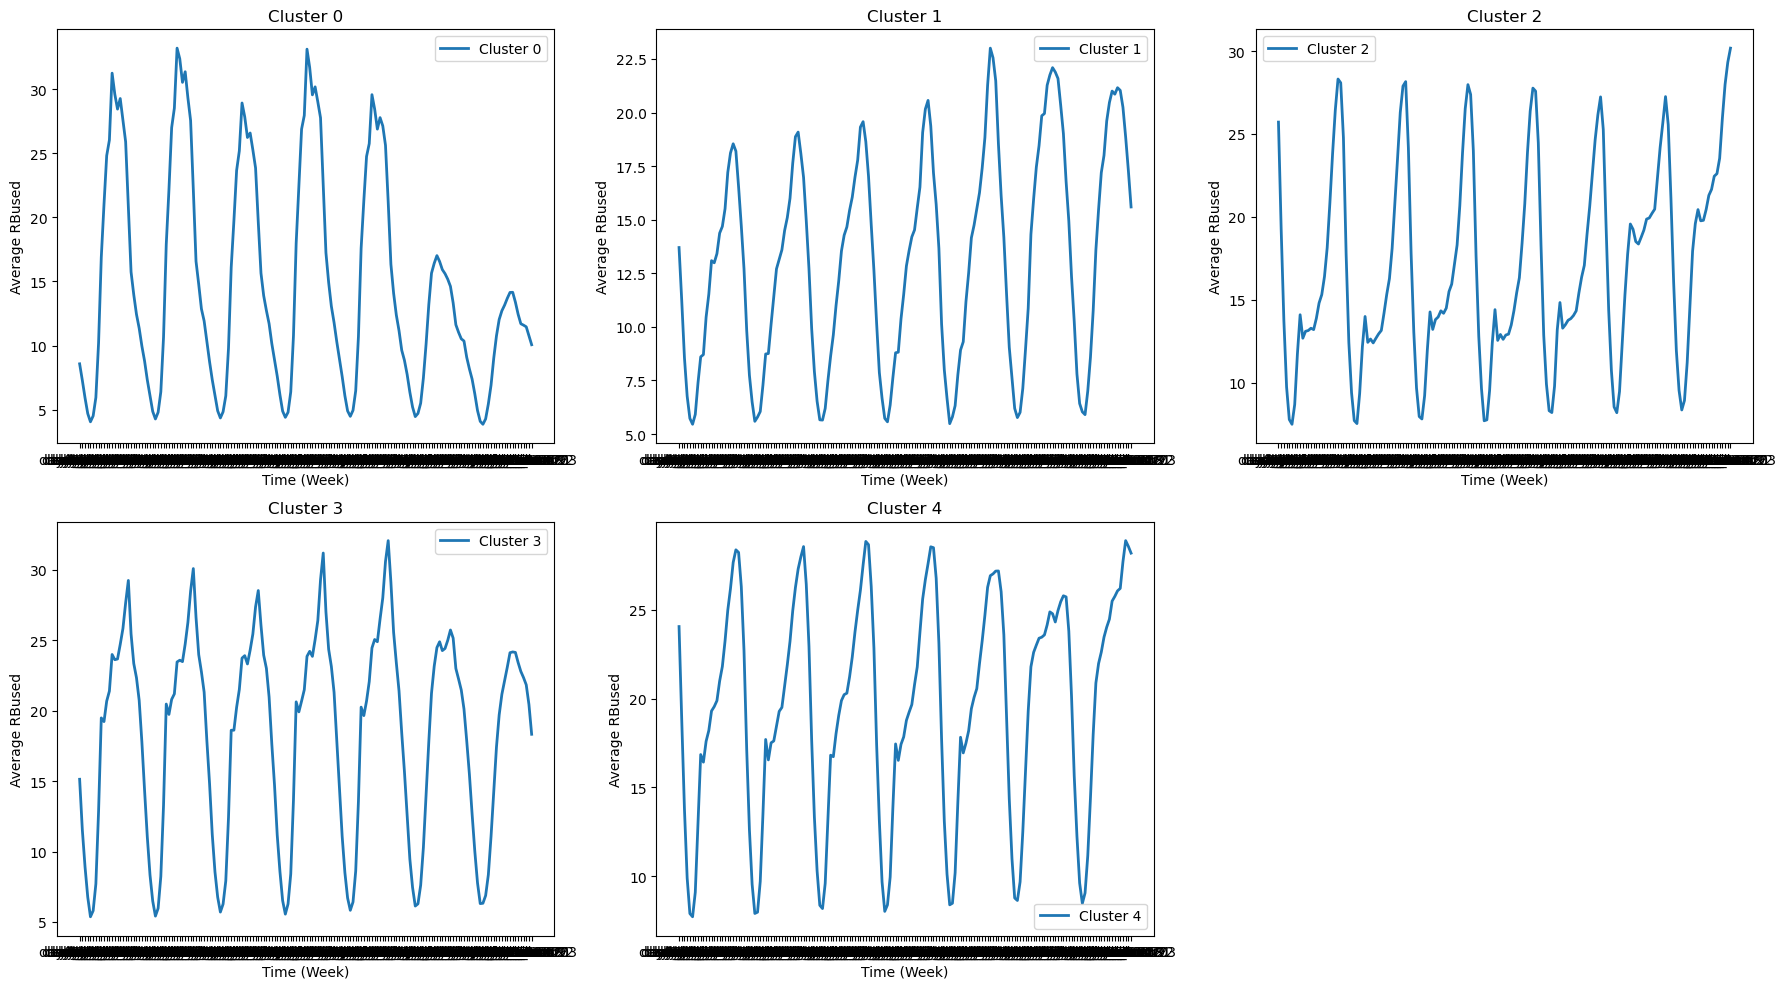

In [19]:
# 클러스터별 평균을 서브플롯으로 시각화
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # 서브플롯을 2x3 형태로 배열
axes = axes.flatten()  # 축을 1차원 배열로 평탄화하여 접근하기 쉽게 함

for cluster_num in range(n_clusters):
    axes[cluster_num].plot(cluster_means.iloc[cluster_num], label=f'Cluster {cluster_num}', linewidth=2)
    axes[cluster_num].set_title(f'Cluster {cluster_num}')
    axes[cluster_num].set_xlabel('Time (Week)')
    axes[cluster_num].set_ylabel('Average RBused')
    axes[cluster_num].legend()

# 빈 서브플롯 제거
for i in range(n_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [37]:
# 지도 시각화
center_lat = weekly_pattern['ru_svc_lat_val'].mean()
center_lng = weekly_pattern['ru_svc_lng_val'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
          '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']

for idx, row in weekly_pattern.iterrows():
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=10,
        popup=f"enbid_pci: {idx}, Cluster: {row['cluster']}",
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fillColor=colors[int(row['cluster']) % len(colors)],
        fillOpacity=0.7,
        stroke=True,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
    <div style="position: fixed; 
    top: 50px; right: 50px; width: 120px; height: 180px; 
    border:2px solid grey; z-index:9999; font-size:14px;
    ">&nbsp; <b>Cluster Legend</b> <br>
'''
for i in range(n_clusters):
    legend_html += f'<i class="fa fa-circle fa-1x" style="color:{colors[i]}"></i>&nbsp; Cluster {i}<br>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장
m.save("kshape_cluster_map.html")

/var/folders/6y/gvfh979s4nb35bcvpht0ntlm0000gn/T/ipykernel_2863/513241462.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'mean'}).reset_index()


Cluster means shape: (6, 168)
Cluster means columns: Index(['day0hour0', 'day0hour1', 'day0hour2', 'day0hour3', 'day0hour4',
       'day0hour5', 'day0hour6', 'day0hour7', 'day0hour8', 'day0hour9',
       ...
       'day6hour14', 'day6hour15', 'day6hour16', 'day6hour17', 'day6hour18',
       'day6hour19', 'day6hour20', 'day6hour21', 'day6hour22', 'day6hour23'],
      dtype='object', length=168)


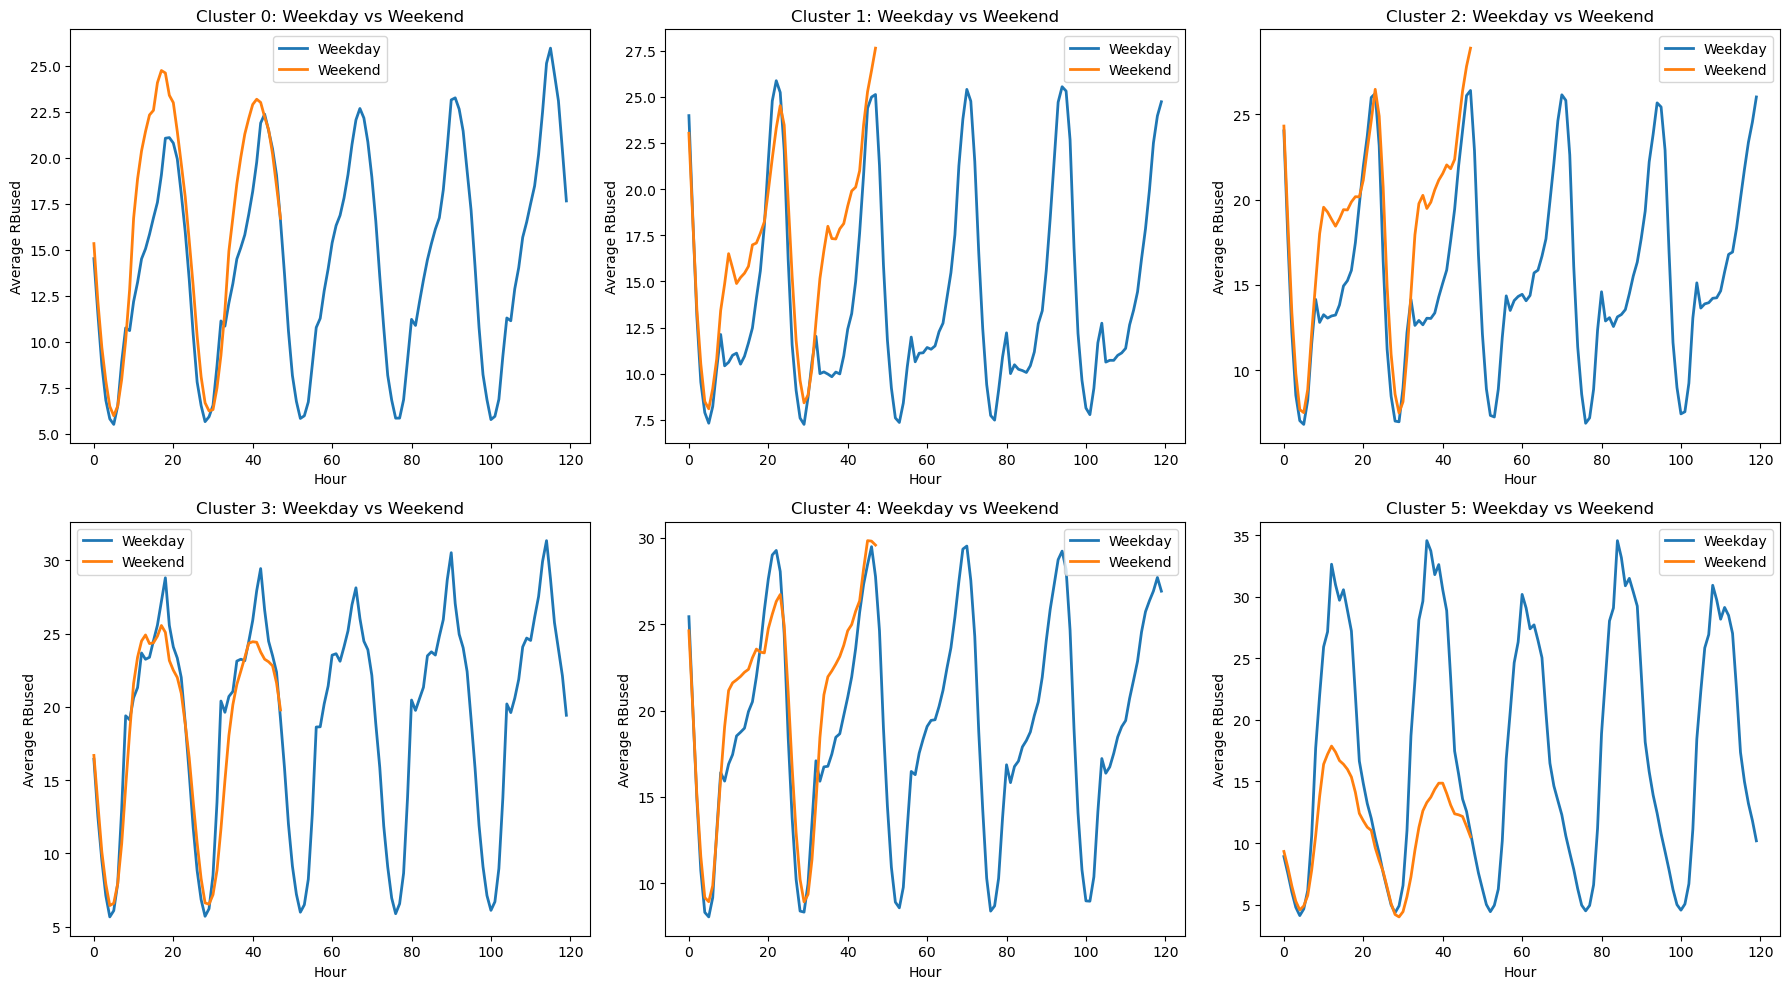


Cluster 0 Statistics:
Number of enbid_pci: 68
Average RBused: 14.82
Weekday Average: 14.31
Weekend Average: 16.09

Cluster 1 Statistics:
Number of enbid_pci: 36
Average RBused: 14.87
Weekday Average: 14.10
Weekend Average: 16.79

Cluster 2 Statistics:
Number of enbid_pci: 56
Average RBused: 16.34
Weekday Average: 15.55
Weekend Average: 18.33

Cluster 3 Statistics:
Number of enbid_pci: 221
Average RBused: 18.65
Weekday Average: 18.97
Weekend Average: 17.84

Cluster 4 Statistics:
Number of enbid_pci: 130
Average RBused: 19.44
Weekday Average: 19.07
Weekend Average: 20.36

Cluster 5 Statistics:
Number of enbid_pci: 135
Average RBused: 15.63
Weekday Average: 17.52
Weekend Average: 10.90

Silhouette Score: 0.1052


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score

# 데이터 로드 및 전처리
df = pd.read_csv('ELG_Busan_PoC_per_CA_site_0226_0519.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'mean'}).reset_index()
df_hourly['day_of_week'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['hour'] = df_hourly['timestamp'].dt.hour
df_hourly['is_weekend'] = df_hourly['day_of_week'].isin([5, 6])

# 주간 패턴 생성
weekly_pattern = df_hourly.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1,2])
weekly_pattern.columns = [f'day{day}hour{hour}' for day, hour in weekly_pattern.columns]

# k-Shape 클러스터링을 위한 데이터 준비
time_series_data = to_time_series_dataset(weekly_pattern.fillna(weekly_pattern.mean()).values)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
time_series_data_scaled = scaler.fit_transform(time_series_data)

# k-Shape 클러스터링 수행
n_clusters = 6  # 클러스터 수는 필요에 따라 조정 가능
kshape = KShape(n_clusters=n_clusters, random_state=42)
cluster_labels = kshape.fit_predict(time_series_data_scaled)

# 결과를 원본 데이터에 추가
weekly_pattern['cluster'] = cluster_labels

# 클러스터별 RBused의 평균 계산
cluster_means = weekly_pattern.groupby('cluster').mean()

# 데이터 구조 확인
print("Cluster means shape:", cluster_means.shape)
print("Cluster means columns:", cluster_means.columns)

# 주중/주말 패턴 분석
def is_weekday(col_name):
    day = int(col_name.split('day')[1].split('hour')[0])
    return day < 5

weekday_columns = [col for col in cluster_means.columns if is_weekday(col)]
weekend_columns = [col for col in cluster_means.columns if not is_weekday(col)]

weekday_pattern = cluster_means[weekday_columns]
weekend_pattern = cluster_means[weekend_columns]

# 주중/주말 패턴 시각화
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for cluster_num in range(n_clusters):
    weekday_data = weekday_pattern.iloc[cluster_num]
    weekend_data = weekend_pattern.iloc[cluster_num]
    axes[cluster_num].plot(range(len(weekday_data)), weekday_data, label='Weekday', linewidth=2)
    axes[cluster_num].plot(range(len(weekend_data)), weekend_data, label='Weekend', linewidth=2)
    axes[cluster_num].set_title(f'Cluster {cluster_num}: Weekday vs Weekend')
    axes[cluster_num].set_xlabel('Hour')
    axes[cluster_num].set_ylabel('Average RBused')
    axes[cluster_num].legend()

# 빈 서브플롯 제거
for i in range(n_clusters, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

# 클러스터별 통계 출력
for cluster_num in range(n_clusters):
    cluster_data = weekly_pattern[weekly_pattern['cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} Statistics:")
    print(f"Number of enbid_pci: {len(cluster_data)}")
    print(f"Average RBused: {cluster_data.iloc[:, :-1].mean().mean():.2f}")
    print(f"Weekday Average: {weekday_pattern.iloc[cluster_num].mean():.2f}")
    print(f"Weekend Average: {weekend_pattern.iloc[cluster_num].mean():.2f}")

# 실루엣 점수 계산
silhouette_avg = silhouette_score(time_series_data_scaled.reshape(time_series_data_scaled.shape[0], -1), cluster_labels)
print(f"\nSilhouette Score: {silhouette_avg:.4f}")

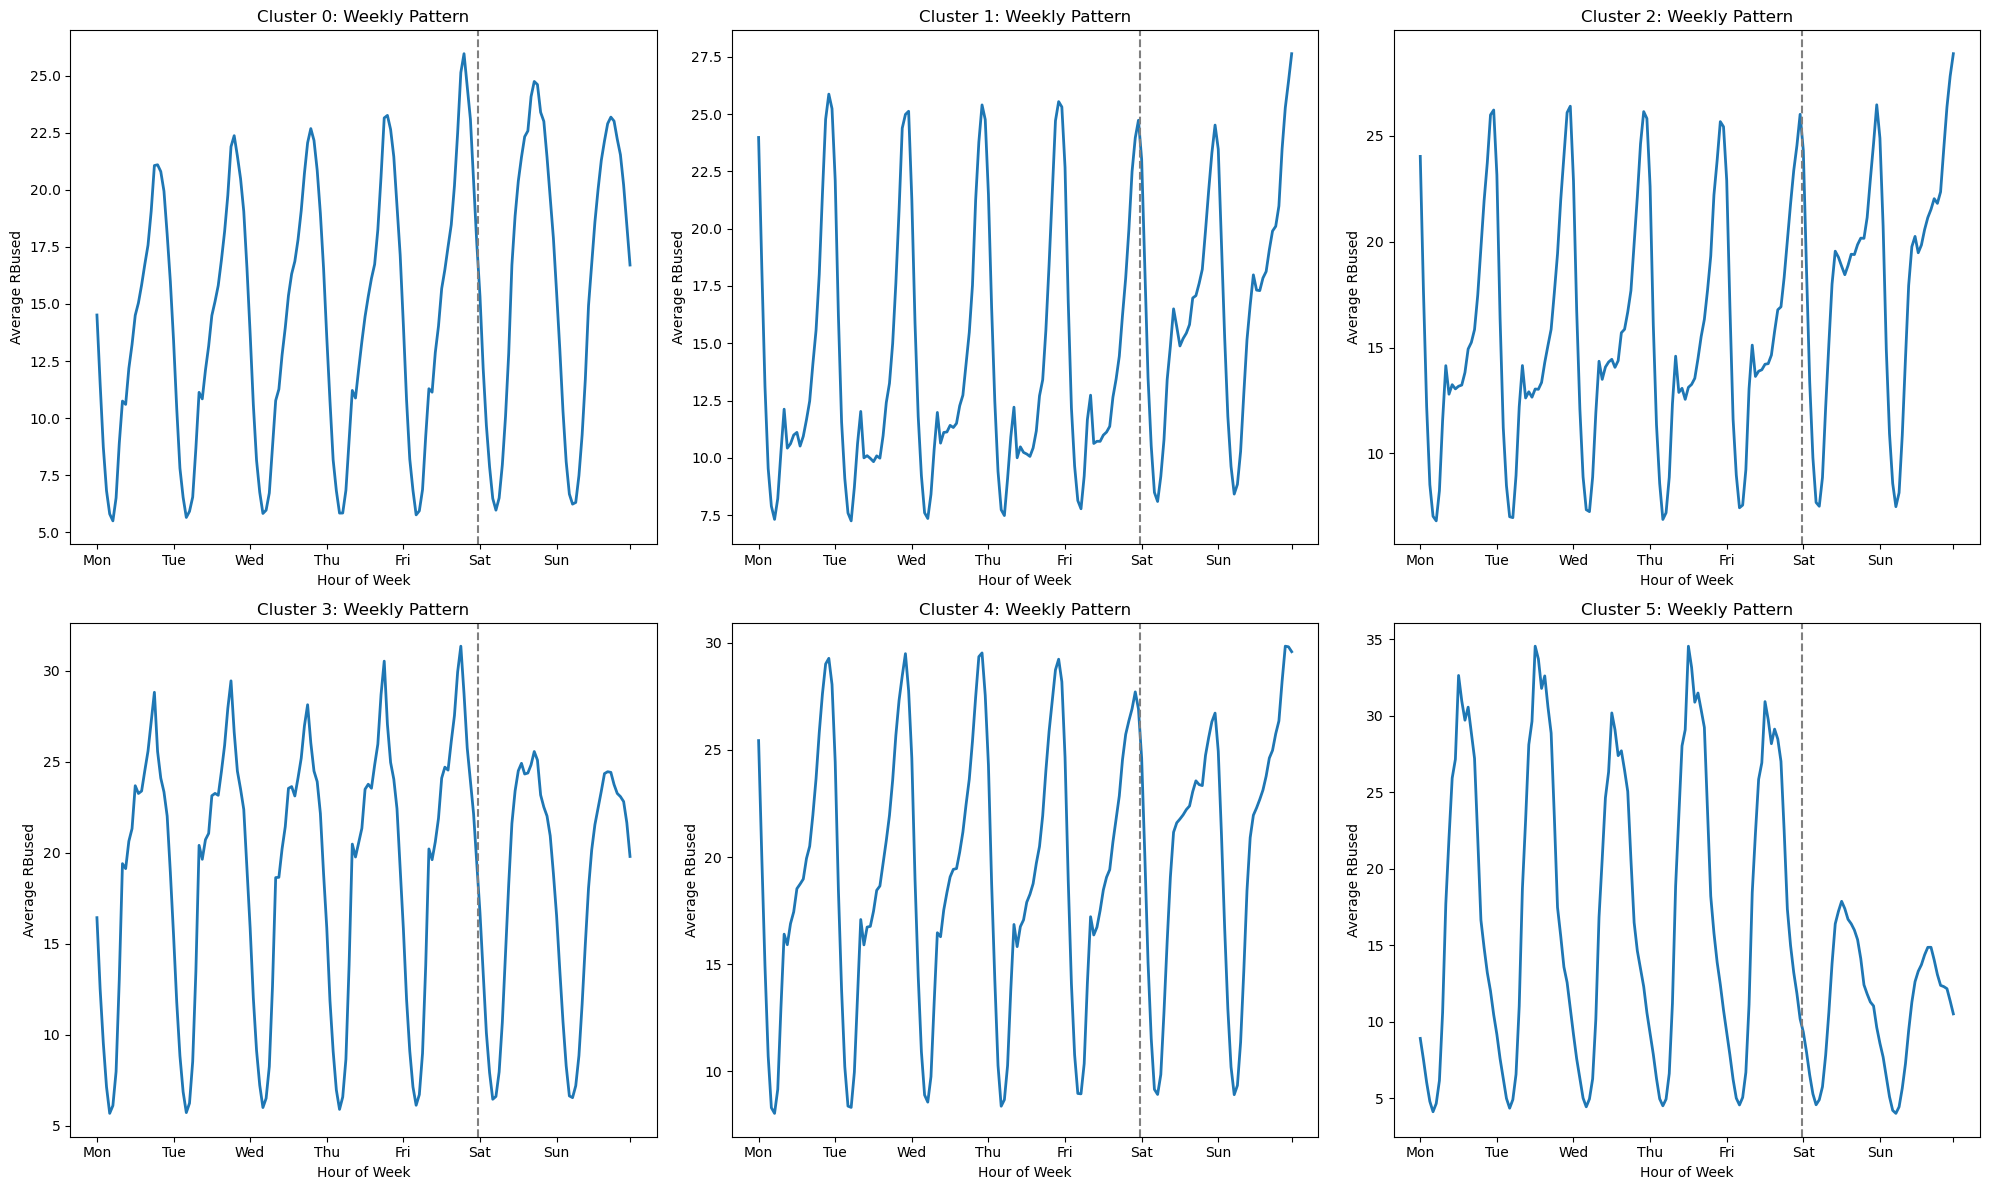

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score

# (이전 코드는 그대로 유지)

# 주중/주말 패턴 시각화 수정
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

for cluster_num in range(n_clusters):
    weekday_data = weekday_pattern.iloc[cluster_num]
    weekend_data = weekend_pattern.iloc[cluster_num]
    
    # 전체 데이터 생성 (평일 + 주말)
    full_data = np.concatenate([weekday_data, weekend_data])
    
    # 시간 축 생성
    time_axis = np.arange(len(full_data))
    
    # 전체 데이터 플롯
    axes[cluster_num].plot(time_axis, full_data, linewidth=2)
    
    axes[cluster_num].set_title(f'Cluster {cluster_num}: Weekly Pattern')
    axes[cluster_num].set_xlabel('Hour of Week')
    axes[cluster_num].set_ylabel('Average RBused')
    
    # 평일과 주말 구분선 추가
    axes[cluster_num].axvline(x=len(weekday_data)-0.5, color='gray', linestyle='--')
    
    # x축 레이블 설정
    axes[cluster_num].set_xticks([0, 24, 48, 72, 96, 120, 144, 167])
    axes[cluster_num].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ''])

# 빈 서브플롯 제거
for i in range(n_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# (이후 코드는 그대로 유지)

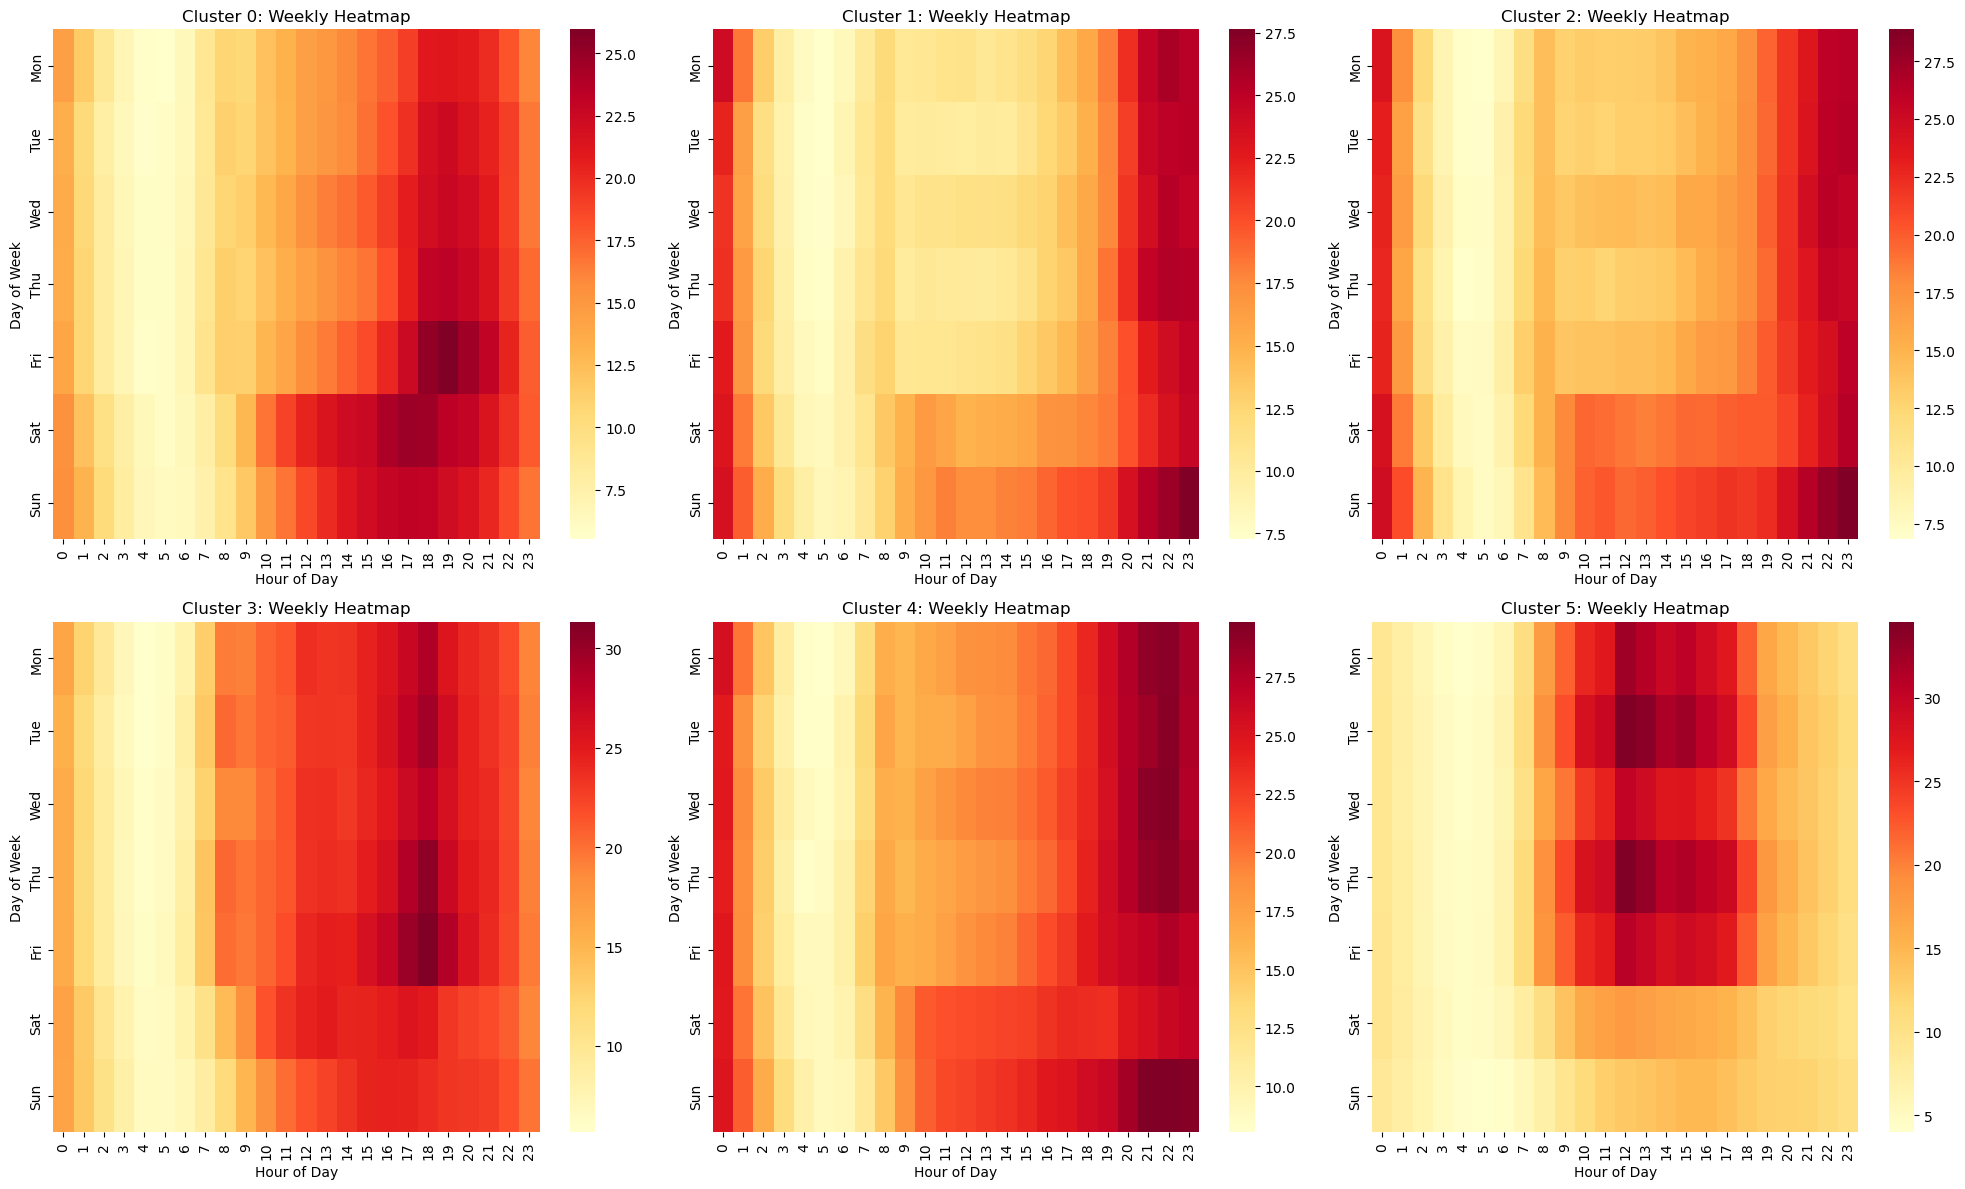


Cluster 0 Statistics:
Number of enbid_pci: 68
Average RBused: 14.82
Weekday Average: 14.31
Weekend Average: 16.09

Cluster 1 Statistics:
Number of enbid_pci: 36
Average RBused: 14.87
Weekday Average: 14.10
Weekend Average: 16.79

Cluster 2 Statistics:
Number of enbid_pci: 56
Average RBused: 16.34
Weekday Average: 15.55
Weekend Average: 18.33

Cluster 3 Statistics:
Number of enbid_pci: 221
Average RBused: 18.65
Weekday Average: 18.97
Weekend Average: 17.84

Cluster 4 Statistics:
Number of enbid_pci: 130
Average RBused: 19.44
Weekday Average: 19.07
Weekend Average: 20.36

Cluster 5 Statistics:
Number of enbid_pci: 135
Average RBused: 15.63
Weekday Average: 17.52
Weekend Average: 10.90

Silhouette Score: 0.1052


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score

# (이전 코드는 그대로 유지)

# 히트맵 시각화를 위한 데이터 준비
def prepare_heatmap_data(cluster_data):
    return cluster_data.values.reshape(7, 24)

# 클러스터별 히트맵 시각화
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

for cluster_num in range(n_clusters):
    cluster_data = cluster_means.iloc[cluster_num]
    heatmap_data = prepare_heatmap_data(cluster_data)
    
    sns.heatmap(heatmap_data, ax=axes[cluster_num], cmap="YlOrRd", 
                xticklabels=range(24), yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    axes[cluster_num].set_title(f'Cluster {cluster_num}: Weekly Heatmap')
    axes[cluster_num].set_xlabel('Hour of Day')
    axes[cluster_num].set_ylabel('Day of Week')

# 빈 서브플롯 제거
for i in range(n_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 클러스터별 통계 출력 (이전 코드 유지)
for cluster_num in range(n_clusters):
    cluster_data = weekly_pattern[weekly_pattern['cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} Statistics:")
    print(f"Number of enbid_pci: {len(cluster_data)}")
    print(f"Average RBused: {cluster_data.iloc[:, :-1].mean().mean():.2f}")
    print(f"Weekday Average: {weekday_pattern.iloc[cluster_num].mean():.2f}")
    print(f"Weekend Average: {weekend_pattern.iloc[cluster_num].mean():.2f}")

# 실루엣 점수 계산 (이전 코드 유지)
silhouette_avg = silhouette_score(time_series_data_scaled.reshape(time_series_data_scaled.shape[0], -1), cluster_labels)
print(f"\nSilhouette Score: {silhouette_avg:.4f}")

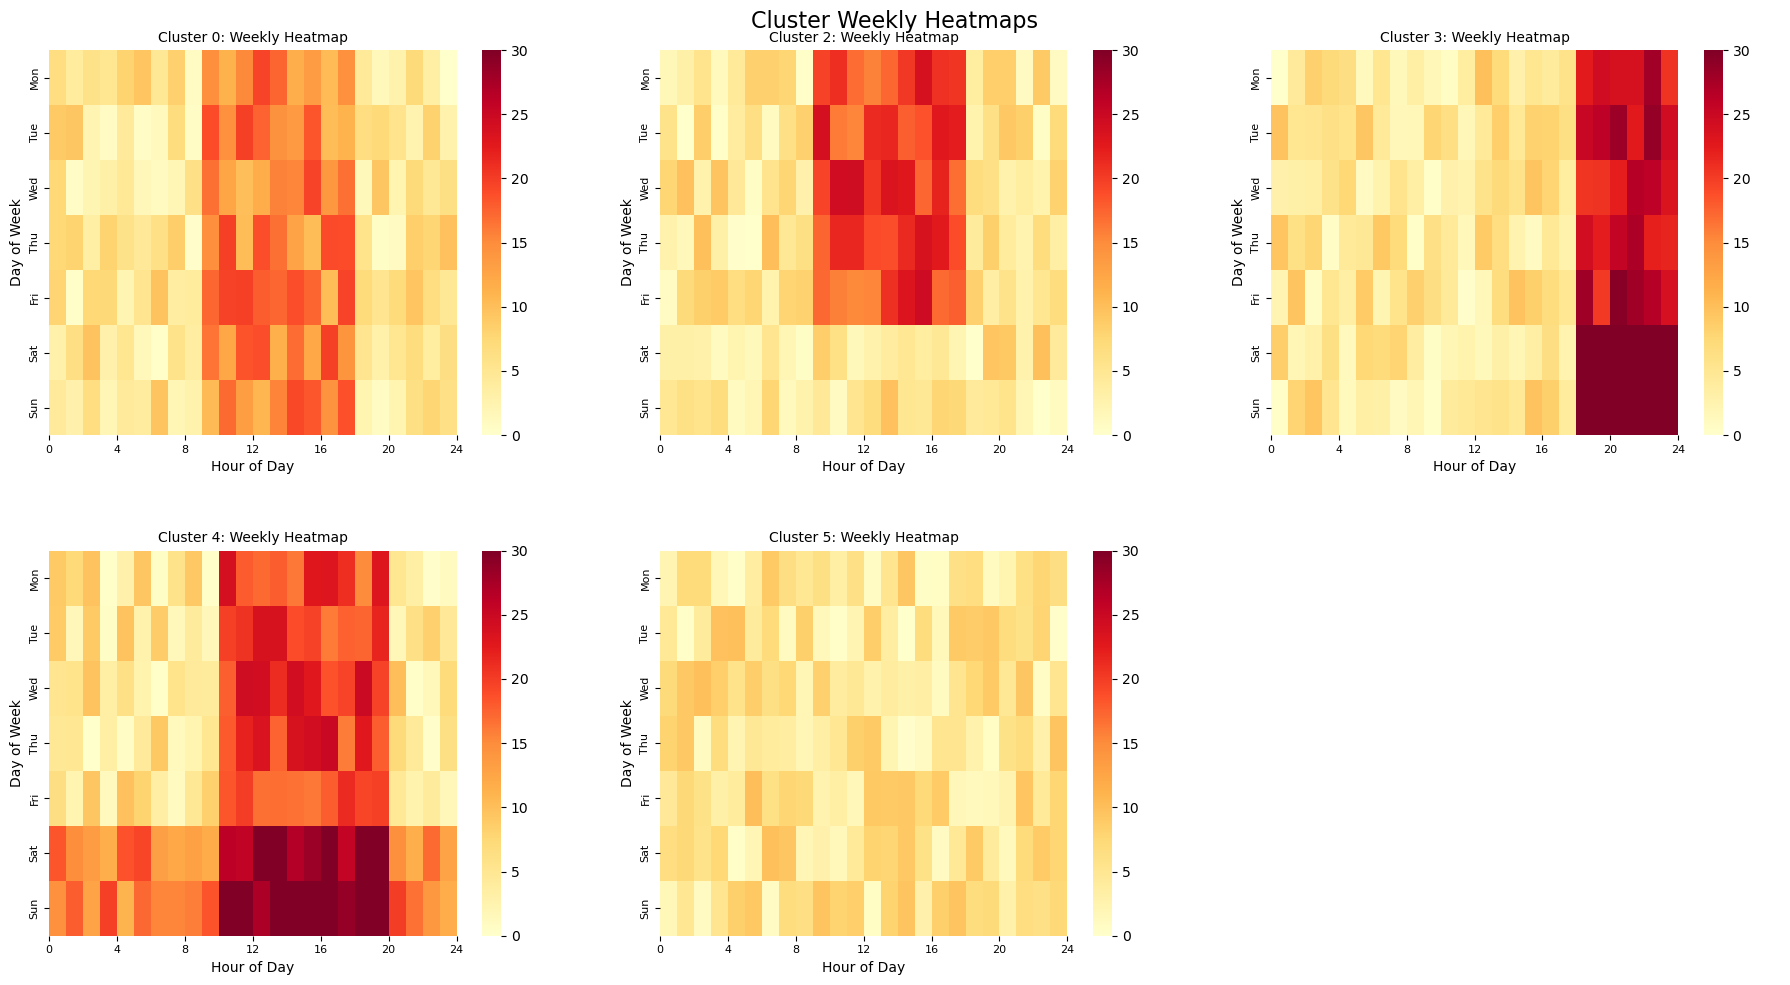

In [67]:
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import branca

# 클러스터링 결과를 enb_id에 매핑
enb_id_cluster = pd.DataFrame({'enb_id': combined_features.index, 'cluster': cluster_labels})

# 원본 데이터에 클러스터 정보 추가
df_with_clusters = df.merge(enb_id_cluster, on='enb_id', how='left')

# 지도 시각화
center_lat = df_with_clusters['ru_svc_lat_val'].mean()
center_lng = df_with_clusters['ru_svc_lng_val'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
          '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']

# enbid_pci별로 그룹화하여 평균 위치와 클러스터 정보 계산
enbid_pci_group = df_with_clusters.groupby('enbid_pci').agg({
    'ru_svc_lat_val': 'mean',
    'ru_svc_lng_val': 'mean',
    'cluster': 'first',  # 각 enbid_pci에 대해 첫 번째 클러스터 값 사용
    'RBused': 'mean'
}).reset_index()

for idx, row in enbid_pci_group.iterrows():
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=10,
        popup=f"enbid_pci: {row['enbid_pci']}, Cluster: {row['cluster']}, Avg RBused: {row['RBused']:.2f}",
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fillColor=colors[int(row['cluster']) % len(colors)],
        fillOpacity=0.7,
        stroke=True,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
     <div style="position: fixed;
     top: 50px; right: 50px; width: 120px; height: 180px;
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Cluster Legend</b> <br>
     '''

for i in range(n_clusters):
    legend_html += f'<i class="fa fa-circle fa-1x" style="color:{colors[i]}"></i>&nbsp; Cluster {i}<br>'

legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장
m.save("/content/drive/MyDrive/Colab_Notebooks/cluster_map_enbid_pci_with_legend.html")

print("클러스터 지도가 '/content/drive/MyDrive/Colab_Notebooks/cluster_map_enbid_pci_with_legend.html'에 저장되었습니다.")

